In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import os, os.path

%matplotlib inline

### Part 1: Visulize data

length of imgs: 16


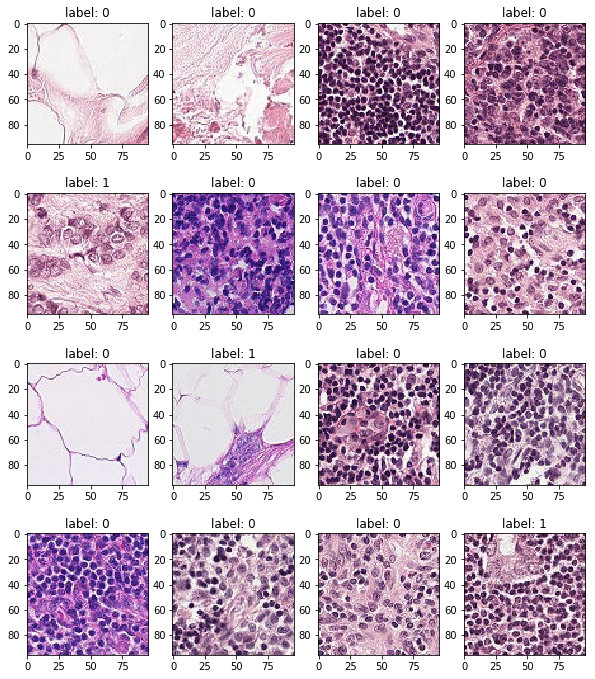

In [90]:
#load images from sample folder
imgs = []
filenames = []
path = "data/sample"
valid_images = [".tif", ".jpg",".gif",".png",".tga"]
for f in os.listdir(path):
    fn = os.path.splitext(f)[0]
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs.append(Image.open(os.path.join(path,f)))
    filenames.append(fn)
print("length of imgs: {}".format(len(imgs)))
#print(filenames)

#get labels for these images
labels = pd.read_csv("data/train_labels.csv")
filelabels = []
for fn in filenames:
    filelabels.append(labels.loc[labels.id == fn, 'label'].values[0])
#print(filelabels)


#visulize loaded images
fig, axes = plt.subplots(4, 4, figsize=(10, 12))
for image, label, ax in zip(imgs, filelabels, axes.ravel()):
    ax.imshow(image)
    ax.set_title("label: {}".format(label))

### Part 2: train and test split, balance train data

In [396]:
#train and test split
from sklearn.model_selection import train_test_split
data = pd.read_csv("data/train_labels.csv")
print("data shape: {}".format(data.shape))
print("positive sample number: {}".format(sum(data.label)))
train_x, test_x, train_y, test_y = train_test_split(data.loc[:, 'id'], data.loc[:, 'label'], 
                                                    test_size=0.8, random_state=16)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, 
                                                      test_size=0.3, random_state=16)
train_data = pd.DataFrame({'id': train_x, 'label': train_y})
valid_data = pd.DataFrame({'id': valid_x, 'label': valid_y})
test_data = pd.DataFrame({'id': test_x, 'label': test_y})
print("samples in train: {}".format(train_data.shape[0]))
print("samples in validation: {}".format(valid_data.shape[0]))
print("samples in test: {}".format(test_data.shape[0]))
train_data.to_csv("data/train.csv")
valid_data.to_csv("data/valid.csv")
test_data.to_csv("data/test.csv")

data shape: (220025, 2)
positive sample number: 89117
samples in train: 30803
samples in validation: 13202
samples in test: 176020


In [105]:
# train = pd.read_csv("data/test.csv")
# train.loc[:, 'label'].value_counts()

0    1335
1     866
Name: label, dtype: int64

### Part 3: load images as Pytorch Dataset

In [92]:
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [123]:
class HistoDataset(Dataset):
    """kaggle histo dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with id and label.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.id = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.id)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.id.iloc[idx, 1]+'.tif')
        image = io.imread(img_name)
        label = self.id.iloc[idx, 2]
        
        if self.transform:
            image = self.transform(image)

        return image, label
    

In [94]:
data = HistoDataset("data/train.csv", "data/train")
data.__getitem__(10)['image'].shape

(96, 96, 3)

In [261]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4)
            )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )

        self.fc = nn.Sequential(
            nn.Linear(2304, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(p=0.50),
            nn.Linear(1000, 1),
            nn.Sigmoid()
            )

    
    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output



In [269]:
net = CNN()
net

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, m

In [371]:
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc

In [393]:

def train_model(epoch=1, batchSize=32):
    EPOCH_NUM = epoch
    BATCH_SIZE = batchSize

    train_dataset = HistoDataset("data/train.csv", "data/train")
    val_dataset = HistoDataset("data/valid.csv", "data/train")
    train_data = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, 
                            shuffle=True, num_workers=2)
    val_data = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, 
                            shuffle=True, num_workers=2)
    
    
    net = CNN()
    
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    
    for epoch in range(EPOCH_NUM):
        train_loss = 0
        for i, (samples, labels) in tqdm(enumerate(train_data)):
            net.train()
            inputs, labels = samples.view((samples.size(0),3, 96, 96)),labels.view(labels.size(0), 1).float()
            #print(labels)
            y_pred = net(inputs)
            #print(y_pred)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#             #output average loss for every 10 runs
#             train_loss += loss.item()
#             if i % 10 == 9:
#                 print("------")
#                 print("running loss for train: {}".format(train_loss / 10))
#                 train_loss = 0
                
#                 net.eval()
#                 val_loss = 0                
#                 for j, (samples, labels) in enumerate(val_data):
#                     inputs, labels = Variable(samples.view((samples.size(0),3, 96, 96))),Variable(labels.view(labels.size(0), 1).float())
#                     y_pred = net(inputs)
#                     loss = criterion(y_pred, labels)
#                     val_loss += loss.item()
#                 print("running loss for validation: {}".format(val_loss / (j+1)))

    #evaluate the performance on validation set
    net.eval()
    pred_values = []
    true_values = []
    for j, (samples, labels) in enumerate(val_data):
        inputs = samples.view((samples.size(0),3, 96, 96))
        pred_values += [x[0] for x in net(inputs).data.numpy()]
        true_values += [x for x in labels.numpy()]
    #print(pred_values)
    #print(true_values)
    fpr, tpr, thres = roc_curve(np.array(true_values), np.array(pred_values))
    auc_score = auc(fpr, tpr)
    print("auc: {}".format(auc_score))
    plt.plot(fpr, tpr, color='blue')
    plt.xlabel("false positive rate", fontsize=14)
    plt.ylabel("true positive rate", fontsize=14)
    plt.title("roc", fontsize=18)




auc: 0.8652215613188237


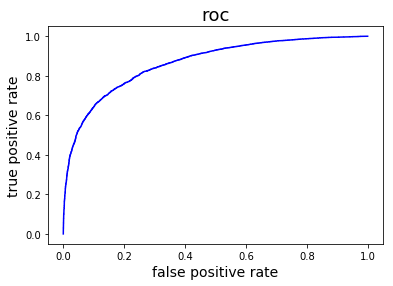

In [397]:
train_model()